<a href="https://colab.research.google.com/github/haydnllh/pi_c_maths/blob/main/%F0%9F%A4%93.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is my first machine learning program.

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import os
import shutil
import math
!pip install -q rembg
import rembg

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
'''!kaggle datasets download -d xainano/handwrittenmathsymbols
!unzip -q handwrittenmathsymbols.zip
!unrar x -inul -y "data.rar"'''

'!kaggle datasets download -d xainano/handwrittenmathsymbols\n!unzip -q handwrittenmathsymbols.zip\n!unrar x -inul -y "data.rar"'

In [9]:
#I love u clarencezhao
!kaggle datasets download -d clarencezhao/handwritten-math-symbol-dataset
!unzip -q handwritten-math-symbol-dataset.zip

 80% 46.0M/57.8M [00:00<00:00, 80.1MB/s]
100% 57.8M/57.8M [00:00<00:00, 86.4MB/s]


In [3]:
def resize(image, d):
  (image_h, image_w) = image.shape
  ar = image_w/image_h
  re_dim = d - d//10
  re_dim_y = int(re_dim*ar)
  re_dim_x = int(re_dim//ar)
  oe = int(not bool(d%2))
  if re_dim_y % 2 == oe:
    re_dim_y += 1
  elif re_dim_x % 2 == oe:
    re_dim_x += 1
  if ar > 1:
    resized = cv2.resize(image, (re_dim,re_dim_x))
  else:
    resized = cv2.resize(image, (re_dim_y,re_dim))
  (re_h,re_w) = resized.shape
  img_box = np.zeros([d,d],"uint8")
  bound_y = round((d-re_h)/2)
  bound_x = round((d-re_w)/2)
  img_box[bound_y:bound_y+re_h,bound_x:bound_x+re_w] = resized
  return img_box

In [4]:
def img_segment(image, dimension):
  kernel = np.ones((5, 5), np.uint8)
  pix = dimension ** 2 * 0.5
  input = np.array(image.shape[:2])
  image_rembg = rembg.remove(image)
  input = image_rembg.copy()
  image_opening = cv2.morphologyEx(image_rembg, cv2.MORPH_OPEN, kernel, iterations = 2)
  co_bg = np.where(image_opening[:,:,3] < 150)
  co_fg = np.where(image_opening[:,:,3] >= 150)
  input[co_bg] = (0,0,0,255)
  input[co_fg] = (255,255,255,255)
  gray_input = cv2.cvtColor(input, cv2.COLOR_BGR2GRAY)
  connected_comp = cv2.connectedComponentsWithStats(gray_input.T, 4, cv2.CV_32S)
  (numLabels, labels, stats) = connected_comp[:3]
  component_list = []
  skip = False
  for i in range(1, numLabels):
    if skip:
      skip = False
      continue
    skip = False
    #think of everything transpose
    bounding_box_x = stats[i, cv2.CC_STAT_LEFT]
    bounding_box_y = stats[i, cv2.CC_STAT_TOP]
    bounding_box_height = stats[i, cv2.CC_STAT_HEIGHT]
    bounding_box_width = stats[i, cv2.CC_STAT_WIDTH]
    area = stats[i, cv2.CC_STAT_AREA]
    bounding_box = labels[bounding_box_y: bounding_box_y + bounding_box_height, bounding_box_x: bounding_box_x + bounding_box_width]
    component = (bounding_box == i).astype("uint8") * 255
    resized = resize(component.T, dimension)
    if np.count_nonzero(resized == 255) > dimension ** 2 * 0.3 and pix < dimension ** 2 * 0.15:
      component_list.pop()
      if stats[i+1, cv2.CC_STAT_LEFT] > stats[i, cv2.CC_STAT_LEFT]:
        left = False
      else:
        left = True
      bounding_box_x = stats[i+int(left), cv2.CC_STAT_LEFT]
      bounding_box_y = stats[i-1, cv2.CC_STAT_TOP]
      bounding_box_width = stats[i+int(not left), cv2.CC_STAT_LEFT] + stats[i+int(not left), cv2.CC_STAT_WIDTH] - bounding_box_x
      bounding_box_height = stats[i-1, cv2.CC_STAT_HEIGHT]
      bounding_box = labels[bounding_box_y: bounding_box_y + bounding_box_height, bounding_box_x: bounding_box_x + bounding_box_width]
      component = np.where(np.isin(bounding_box, [i-1, i, i+1]), 255, bounding_box).astype('uint8')
      resized = resize(component.T, dimension)
      skip = True
    cv2_imshow(resized)
    pix = np.count_nonzero(resized == 255)
    resized = np.expand_dims(resized, axis=2)
    input = np.expand_dims(resized, axis=0)
    component_list.append(input)
  return component_list

Saving IMG_1725.jpg to IMG_1725 (5).jpg


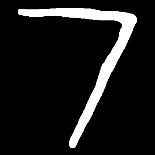

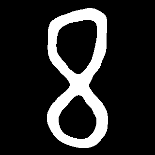

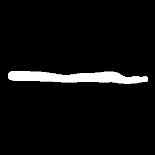

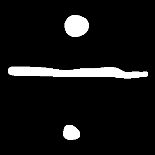

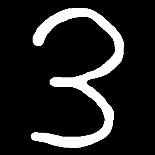

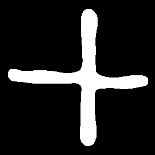

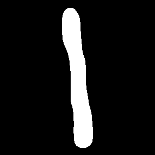

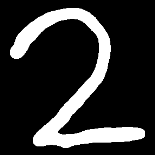

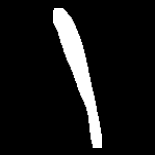

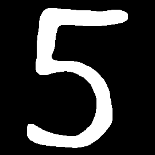

In [5]:
from google.colab import files
uploaded = files.upload()
file_name = next(iter(uploaded.keys()))
path = os.path.join("/content", file_name)
image = cv2.imread(path)
op_list = img_segment(image,155)
mnist_list = img_segment(image,28)

In [6]:
from keras.models import load_model
model_mnist = load_model('/content/drive/MyDrive/models/model_mnist.keras')
model_op = load_model('/content/drive/MyDrive/models/model_op.keras')

In [15]:
def normalise(image, label):
  return tf.cast(image, tf.float32)/255.0, label
'''desired_class = ['+', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'times', 'div']
path = "/content/extracted_images"
for folders in os.listdir(path):
  if folders not in desired_class:
    shutil.rmtree(os.path.join(path,folders))
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/extracted_images",
    labels = "inferred",
    color_mode = 'grayscale',
    image_size = (45,45),
    batch_size = 1024,
    class_names = desired_class,
    shuffle = True,
    seed = 719,
)
ds_train = ds_train.map(function)
ds_train.cache()'''

'desired_class = [\'+\', \'-\', \'0\', \'1\', \'2\', \'3\', \'4\', \'5\', \'6\', \'7\', \'8\', \'9\', \'times\', \'div\']\npath = "/content/extracted_images"\nfor folders in os.listdir(path):\n  if folders not in desired_class:\n    shutil.rmtree(os.path.join(path,folders))\nds_train = tf.keras.preprocessing.image_dataset_from_directory(\n    "/content/extracted_images",\n    labels = "inferred",\n    color_mode = \'grayscale\',\n    image_size = (45,45),\n    batch_size = 1024,\n    class_names = desired_class,\n    shuffle = True,\n    seed = 719,\n)\nds_train = ds_train.map(function)\nds_train.cache()'

In [16]:
desired_class = ['plus cleaned', 'minus', 'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'times', 'div']
path = "/content/train"
for folders in os.listdir(path):
  if folders not in desired_class:
    shutil.rmtree(os.path.join(path,folders))
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    labels = "inferred",
    color_mode = 'grayscale',
    image_size = (155,155),
    batch_size = 64,
    class_names = desired_class,
    shuffle = True,
    seed = 719,
)
ds_train = ds_train.map(normalise)
ds_train.cache()

Found 6490 files belonging to 14 classes.


<CacheDataset element_spec=(TensorSpec(shape=(None, 155, 155, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [17]:
import tensorflow_datasets as tfds
(x_train,x_test), info= tfds.load(
    "mnist",
    batch_size = 2000,
    split = ["train","test"],
    shuffle_files = True,
    with_info = True,
    as_supervised = True
)
x_train = x_train.map(normalise)
x_train.cache()

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


<CacheDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [41]:
model_mnist = keras.Sequential([
    layers.Conv2D(filters = 16, kernel_size = 3, activation = "relu", kernel_initializer = 'he_normal', padding = 'same', input_shape = [28,28,1]),
    layers.Conv2D(filters = 8, kernel_size = 3, activation = "relu", kernel_initializer = 'he_normal', padding = 'same'),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.Flatten(),
    layers.Dense(units = 10, activation = "softmax")
])

In [19]:
model_op = keras.Sequential([
    layers.Conv2D(filters = 32, kernel_size = 7, activation = "relu", padding = 'same', input_shape = [155,155,1]),
    layers.MaxPooling2D(pool_size = (4,4)),
    layers.Conv2D(filters = 16, kernel_size = 5, activation = "relu", padding = 'same'),
    layers.MaxPooling2D(pool_size = (4,4)),
    layers.Flatten(),
    layers.Dense(units = 14, activation = "softmax")
])

In [42]:
model_mnist.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.1),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model_mnist.fit(
    x_train,
    validation_data = x_test,
    epochs = 40,
    verbose = 0
)

In [21]:
model_op.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model_op.fit(
    ds_train,
    epochs = 10,
    verbose = 0
)

Epoch 1/10
102/102 - 4s - loss: 2.6099 - accuracy: 0.1086 - 4s/epoch - 42ms/step
Epoch 2/10
102/102 - 2s - loss: 2.1294 - accuracy: 0.3547 - 2s/epoch - 22ms/step
Epoch 3/10
102/102 - 2s - loss: 1.3354 - accuracy: 0.6065 - 2s/epoch - 22ms/step
Epoch 4/10
102/102 - 6s - loss: 0.9744 - accuracy: 0.7179 - 6s/epoch - 56ms/step
Epoch 5/10
102/102 - 4s - loss: 0.7028 - accuracy: 0.7963 - 4s/epoch - 42ms/step
Epoch 6/10
102/102 - 2s - loss: 0.5281 - accuracy: 0.8505 - 2s/epoch - 23ms/step
Epoch 7/10
102/102 - 2s - loss: 0.4276 - accuracy: 0.8724 - 2s/epoch - 22ms/step
Epoch 8/10
102/102 - 2s - loss: 0.3650 - accuracy: 0.8945 - 2s/epoch - 24ms/step
Epoch 9/10
102/102 - 4s - loss: 0.3076 - accuracy: 0.9097 - 4s/epoch - 38ms/step
Epoch 10/10
102/102 - 2s - loss: 0.2602 - accuracy: 0.9237 - 2s/epoch - 23ms/step


In [7]:
def num_pop(stack, num_list):
  number = int("".join(stack))
  stack.clear()
  num_list.append(number)
  return stack, num_list

In [8]:
numbers, stack, operation_queue = [], [], []
for i in range(len(mnist_list)):
  number = str(np.argmax(model_mnist.predict(mnist_list[i])))
  op_predictions = model_op.predict(op_list[i])
  operator = np.argmax(op_predictions)
  if 2 <= operator <= 11:
    stack.append(number)
  else:
    stack, numbers = num_pop(stack, numbers)
    operation_queue.append(operator)
stack, numbers = num_pop(stack, numbers)
stack.append(numbers[0])
n3 = 0
for i in range(1,len(numbers)):
  n1 = stack.pop()
  n2 = numbers[i]
  match operation_queue.pop(0):
    case 0:
      n3 = n1 + n2
    case 1:
      n3 = n1 - n2
    case 12:
      n3 = n1 * n2
    case 13:
      n3 = n1 / n2
  stack.append(n3)
print("The answer is", stack.pop(), numbers)

1/1 [==============================] - 0s 24ms/step
The answer is 1239.0 [78, 3, 1213]


In [46]:
'''model_mnist.save('model_mnist.keras')
model_op.save('model_op.keras')
!mv model_mnist.keras /content/drive/MyDrive/models
!mv model_op.keras /content/drive/MyDrive/models'''